In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
import os
os.chdir('/content/drive/My Drive/extrasensory_Xu')
os.getcwd()

'/content/drive/My Drive/extrasensory_Xu'

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from utilize.data import *
from utilize.transform import *
from utilize.feature_selection import *
from utilize.test import *
from utilize.model import *

In [0]:
import importlib
import utilize.transform as transform
import utilize.test as test
import utilize.model as model
import utilize.feature_selection as feature_selection
importlib.reload(transform)
importlib.reload(test)
importlib.reload(model)
importlib.reload(feature_selection)

<module 'utilize.feature_selection' from '/content/drive/My Drive/extrasensory_Xu/utilize/feature_selection.py'>

In [0]:
import os 
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from random import random

In [0]:
os.listdir('result')

['f_20.csv',
 'f_20_1.csv',
 'f_225_1.csv',
 'f_225_2.csv',
 'f_50_1.csv',
 'f_50_2.csv',
 'random_selection_0420.json',
 'f_225_l_51_1.csv',
 'f_225_l_51_2.csv',
 'df_f_225_1_test.json',
 'rrfs_logmatrix.json',
 'random_selection_test.json']

In [0]:
df_f_225_1 = load_log_matric('f_225_1.csv')
df_f_225_2 = load_log_matric('f_225_2.csv')
f_225_l_51_1 = load_log_matric('f_225_l_51_1.csv')
f_225_l_51_2 = load_log_matric('f_225_l_51_2.csv')
f_225_l_51_3 = load_log_matric('f_225_l_51_3.csv')
f_225_l_51_4 = load_log_matric('f_225_l_51_4.csv')
log_matric = pd.read_json('result/random_selection_0420.json')

# Initial

## Methods

In [0]:
# Used to load the selection result from files
def load_log_matric(filename):
    path = os.path.join('result', filename)
    df = pd.read_csv(path, index_col = 0)
    df.loc[1, 'feature_idx'] = df.loc[1, 'feature_idx'].split(',')[0] + df.loc[1, 'feature_idx'].split(',')[1]
    df['features'] = [[int(f) for f in features[1:-1].split(',')] for features in df['feature_idx']]
    df['n_features'] = [len(features) for features in df['features']]
    df['avg_score'] = [float(avg_score) for avg_score in df['avg_score']]
    t = []
    for i in range(225):
      for f in df.loc[i+1, 'features']:
        if f not in t:
          t.append(f)
    
    return pd.DataFrame({'n_features': df['n_features'], 'features': df['features'], 'avg_score': df['avg_score'], 'selected_features': t})

In [0]:
def repeat_selection_on_test(fs, n_feature_steps, average = 5): 
  log_matric = pd.DataFrame({'n_feature_steps':[], 'scores':[]})
  BA_list = []
  for n_feature in n_feature_steps:

    BAs = []
    for i in range(average): 
      try:
        fs.fit() 
      except:
        None
      X_train_new = fs.transform(X_train, k_features = n_feature)
      X_test_new = fs.transform(X_test, k_features = n_feature)

      assert X_test_new.shape[1] == n_feature

      mlp.fit(X_train_new, y_train, X_test_new, y_test, M_train, M_test, report = False)
      _, _, _, BA = evaluate_model(mlp, X_test_new, y_test, abs(1-M_test))
      BAs.append(BA)

    BA_list.append(BAs)
  log_matric['n_feature_steps'] = n_feature_steps
  log_matric['scores'] = BA_list
  log_matric['average_score'] = [sum(BAs)/average for BAs in log_matric['scores']]
  log_matric['max_score'] = [max(BAs) for BAs in log_matric['scores']]

  return log_matric

In [0]:
class random_selector():
  
  def __init__(self, n_features = 225):
    self.n_features = n_features

  def feature_index(self, k_features = 175):
    np.random.seed(self.seed)
    indice = np.random.permutation(self.n_features)

    return indice[:k_features]

  def transform(self, X, k_features = 175):

    indice = self.feature_index(k_features)

    return X[:, indice]

  def fit(self):

    self.seed = int(random()*100)

In [0]:
class SFS_tracker():

  def __init__(self, df):
    self.df = df
  
  def feature_index(self, k_features = 175):
    indice = self.df.loc[k_features, 'features']

  def transform(self, X, k_features = 175):

    indice = self.feature_index(k_features)

    return X[:, indice]

  def fit(self): 

    return

## Data

In [0]:
X, y, M, user_index, feature_names, label_names = load_all_data()

# Only select body state label
target_label = ['LYING_DOWN', 'SITTING', 'FIX_walking', 'FIX_running', 'BICYCLING', 'OR_standing']

# Use the last 5 user's data as test set
test_uuid = list(range(56, 61))

# Fill the Nan with mean value and normalize all the data 
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())
])

# Transform 
# 1. select target labels 
# 2. tansform feature matrix fill None with mean and do the normalization
# 3. Split train, validation and test set by ratio of 6:2:2
X_new, y_new, M_new = select_target_labels(X, y, M, target_label, label_names, drop_all_zero = False)
X_new = pipeline.fit_transform(X_new, y_new)
X_train, y_train, M_train, X_val, y_val, M_val, X_test, y_test, M_test = random_split(X_new, y_new, M_new, test_size = 0.2, val_size = 0.2, random_seed = 42)

# Repeat the fitting on test data

## Plot the result 

In [0]:
SFS_test = pd.read_json('result/df_f_225_1_test.json')
RRFS_test = pd.read_json('result/rrfs_logmatrix.json')
Random_test = pd.read_json('result/random_selection_test.json')

Text(0, 0.5, 'balanced accuracy score')

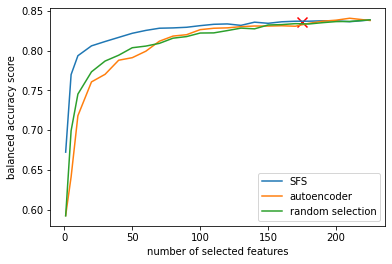

In [139]:
plt.plot(SFS_test['n_feature_steps'], SFS_test['average_score'], RRFS_test['n_feature_steps'], RRFS_test['average_score'], Random_test['n_feature_steps'], Random_test['average_score'])
plt.scatter(175, 0.8364498018845603, marker = 'x', c = 'red', s = 100, zorder = 1)
plt.legend(['SFS', 'autoencoder', 'random selection'])
plt.xlabel('number of selected features')
plt.ylabel('balanced accuracy score')

Text(0, 0.5, 'balanced accuracy score')

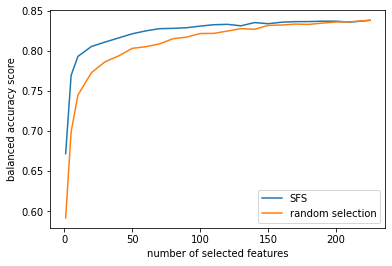

In [141]:
plt.plot(SFS_test['n_feature_steps'], SFS_test['average_score'], Random_test['n_feature_steps'], Random_test['average_score'])
# plt.scatter(175, 0.8364498018845603, marker = 'x', c = 'red', s = 100, zorder = 1)
plt.legend(['SFS', 'random selection'])
plt.xlabel('number of selected features')
plt.ylabel('balanced accuracy score')

Text(0, 0.5, 'balanced accuracy score')

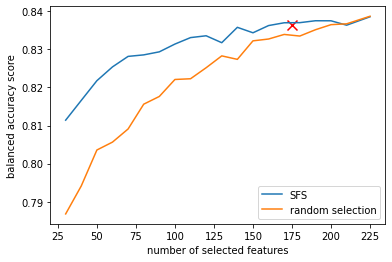

In [143]:
plt.plot(SFS_test['n_feature_steps'][4:], SFS_test['average_score'][4:], Random_test['n_feature_steps'][4:], Random_test['average_score'][4:])
plt.scatter(175, 0.8364498018845603, marker = 'x', c = 'red', s = 100, zorder = 1)
plt.legend(['SFS', 'random selection'])
plt.xlabel('number of selected features')
plt.ylabel('balanced accuracy score')

## Repeat random selector 

In [0]:
rfs = random_selector()
rfs.fit()
rfs.feature_index(255).shape

(225,)

In [0]:
mlp = MLP_model([16, 16], target_label, epoches = 20, learning_rate = 0.00005)
n_feature_steps = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 225]
random_selection_log = repeat_selection_on_test(rfs, n_feature_steps, average = 10)

accuaracy      sensitivity    specificity    BA             
0.681066       0.567866       0.649015       0.608441       
accuaracy      sensitivity    specificity    BA             
0.693835       0.501891       0.709374       0.605632       
accuaracy      sensitivity    specificity    BA             
0.622303       0.333350       0.666676       0.500013       
accuaracy      sensitivity    specificity    BA             
0.657068       0.476156       0.677954       0.577055       
accuaracy      sensitivity    specificity    BA             
0.583670       0.631381       0.573026       0.602203       
accuaracy      sensitivity    specificity    BA             
0.604791       0.692859       0.581789       0.637324       
accuaracy      sensitivity    specificity    BA             
0.431511       0.828140       0.393017       0.610579       
accuaracy      sensitivity    specificity    BA             
0.644678       0.589502       0.604061       0.596782       
accuaracy      sensitivi

In [0]:
random_selection_log.to_json('result/random_selection_test.json')

In [0]:
random_selection_log = pd.read_json('result/random_selection_test.json')

In [0]:
random_selection_log

,n_feature_steps,scores,average_score,max_score
0,1,"[0.6084405576, 0.6056324026000001, 0.500012890...",0.591969,0.664255
1,5,"[0.6619717626, 0.6844939344000001, 0.723132696...",0.699132,0.733861
2,10,"[0.7534223578, 0.7484011581000001, 0.729499873...",0.745264,0.763431
3,20,"[0.7824615319, 0.776072614, 0.7637064272, 0.78...",0.773274,0.782462
4,30,"[0.7801046003000001, 0.7864919305, 0.780651370...",0.786817,0.799745
5,40,"[0.7986459843, 0.804202575, 0.7876447848, 0.79...",0.794160,0.804203
6,50,"[0.796208715, 0.8094940192000001, 0.8024448394...",0.803579,0.809494
7,60,"[0.8044316888, 0.8121174562, 0.7985967134, 0.8...",0.805652,0.812604
8,70,"[0.8063690568, 0.8028154649, 0.8033793872, 0.8...",0.809098,0.822793
9,80,"[0.8111859628, 0.8132920343000001, 0.817013331...",0.815598,0.821708


## Repeat on single points

In [136]:
fs = select_features_by_sensors(['Loc', 'Acc', 'Gyro', 'WAcc', 'PS', 'Aud'], feature_names)
X_train_new = fs.fit_transform(X_train)
X_test_new = fs.transform(X_test)
X_train_new.shape

(226408, 175)

In [137]:
mlp = MLP_model([16, 16], target_label, epoches = 30, learning_rate = 0.00005)
BA_list = []
for i in range(10): 
  mlp.fit(X_train, y_train, X_test, y_test, M_train, M_test, report = False)
  _, _, _, BA = evaluate_model(mlp, X_test, y_test, abs(1-M_test))
  BA_list.append(BA)

accuaracy      sensitivity    specificity    BA             
0.851826       0.829201       0.839232       0.834217       
accuaracy      sensitivity    specificity    BA             
0.836480       0.852670       0.825890       0.839280       
accuaracy      sensitivity    specificity    BA             
0.855352       0.826029       0.846900       0.836465       
accuaracy      sensitivity    specificity    BA             
0.794874       0.895130       0.764532       0.829831       
accuaracy      sensitivity    specificity    BA             
0.848230       0.829477       0.842290       0.835883       
accuaracy      sensitivity    specificity    BA             
0.829278       0.861712       0.815257       0.838484       
accuaracy      sensitivity    specificity    BA             
0.826704       0.857826       0.824705       0.841266       
accuaracy      sensitivity    specificity    BA             
0.816139       0.875563       0.801949       0.838756       
accuaracy      sensitivi

In [138]:
sum(BA_list)/10

0.8364498018845603


# 51 label result

## Plot scatter of SFS

### Prepare the feature info

In [0]:
sensor_name_abbriviation = {
    'raw_acc': 'Acc',
    'proc_gyro': 'Gyro', 
    'raw_magnet': 'Magnet',
    'watch_acceleration': 'WAcc',
    'watch_heading': 'Compass',
    'location': 'Loc',
    'location_quick_features': 'Loc',
    'audio_naive': 'Aud',
    'audio_properties': 'AP',
    'discrete': 'PS', 
    'lf_measurements': 'LF'
}

class select_features_by_sensors(BaseEstimator, TransformerMixin):

    '''
    Select feature by given sensor names. Compatible with sklearn transformer class.

    Keyword Arguments:
        sensors_to_use: [list] -- feature names in list we want to select
        feature_names: [list] -- feature names of all the possible features 
    '''

    def __init__(self, sensors_to_use, feature_names):
        self.sensors_to_use = sensors_to_use
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        fi = []
        for i, feature in enumerate(self.feature_names):
            if sensor_name_abbriviation[feature.split(':')[0]] in self.sensors_to_use:
                fi.append(i)
    
        return X[:, fi]

def get_sensor_names_from_features(feature_names, return_name = True):
    feat_sensor_names = np.array([None for feat in feature_names]);
    for (fi,feat) in enumerate(feature_names):
        if feat.startswith('raw_acc'):
            feat_sensor_names[fi] = 'Acc' if return_name else 1;
            pass;
        elif feat.startswith('proc_gyro'):
            feat_sensor_names[fi] = 'Gyro' if return_name else 2;
            pass;
        elif feat.startswith('raw_magnet'):
            feat_sensor_names[fi] = 'Magnet' if return_name else 3;
            pass;
        elif feat.startswith('watch_acceleration'):
            feat_sensor_names[fi] = 'WAcc' if return_name else 4;
            pass;
        elif feat.startswith('watch_heading'):
            feat_sensor_names[fi] = 'Compass' if return_name else 5;
            pass;
        elif feat.startswith('location'):
            feat_sensor_names[fi] = 'Loc' if return_name else 6;
            pass;
        elif feat.startswith('location_quick_features'):
            feat_sensor_names[fi] = 'Loc' if return_name else 6;
            pass;
        elif feat.startswith('audio_naive'):
            feat_sensor_names[fi] = 'Aud' if return_name else 7;
            pass;
        elif feat.startswith('audio_properties'):
            feat_sensor_names[fi] = 'AP' if return_name else 8;
            pass;
        elif feat.startswith('discrete'):
            feat_sensor_names[fi] = 'PS' if return_name else 9;
            pass;
        elif feat.startswith('lf_measurements'):
            feat_sensor_names[fi] = 'LF' if return_name else 10;
            pass;
        else:
            raise ValueError("!!! Unsupported feature name: %s" % feat);

        pass;

    return feat_sensor_names; 

sensor_list_num = get_sensor_names_from_features(feature_names, return_name = False)
sensor_list = get_sensor_names_from_features(feature_names, return_name = True)

### Plot scatter

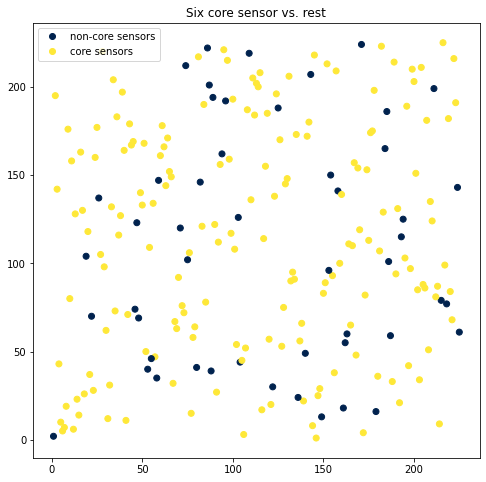

In [14]:
def plot_scatter(df1, df2):
  x1 = [0]*226
  for i, f in enumerate(df1['selected_features']):
    x1[f] = i + 1
  x1.remove(0)

  x2 = [0]*226
  for i, f in enumerate(df2['selected_features']):
    x2[f] = i + 1
  x2.remove(0)
  fig = plt.figure(figsize= (8, 8))

  scatter = plt.scatter(x1, x2, c = [1 if i in [1, 2, 6, 7, 9, 4] else -1 for i in sensor_list_num], cmap='cividis')
  plt.legend(handles=scatter.legend_elements()[0], labels = ['non-core sensors', 'core sensors'])
  plt.title('Six core sensor vs. rest')
  plt.show()
plot_scatter(f_225_l_51_3, f_225_l_51_4)

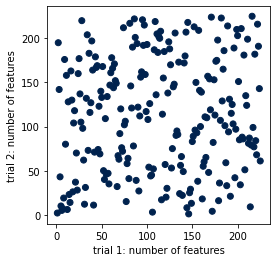

In [150]:
def plot_scatter(df1, df2):
  x1 = [0]*226
  for i, f in enumerate(df1['selected_features']):
    x1[f] = i + 1
  x1.remove(0)

  x2 = [0]*226
  for i, f in enumerate(df2['selected_features']):
    x2[f] = i + 1
  x2.remove(0)
  fig = plt.figure(figsize= (4, 4))

  scatter = plt.scatter(x1, x2, c = [0]*225, cmap='cividis')
  #plt.legend(handles=scatter.legend_elements()[0], labels = ['Others', 'Acc'])
  # plt.title('Acc vs. rest')
  plt.xlabel('trial 1: number of features')
  plt.ylabel('trial 2: number of features')
  plt.show()
plot_scatter(f_225_l_51_3, f_225_l_51_4)

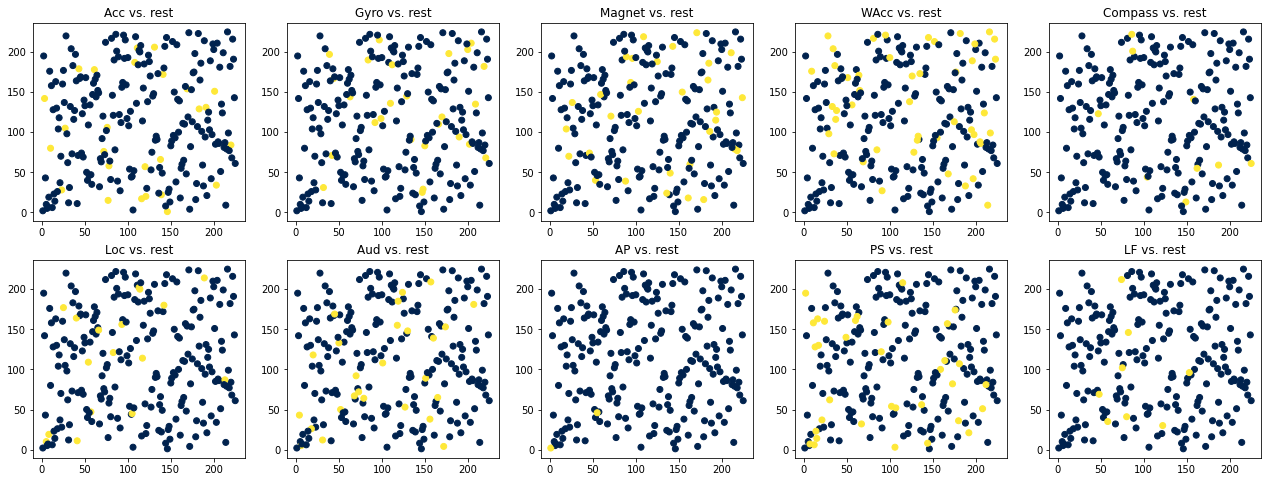

In [18]:
def plot_scatter(df1, df2):
  x1 = [0]*226
  for i, f in enumerate(df1['selected_features']):
    x1[f] = i + 1
  x1.remove(0)

  x2 = [0]*226
  for i, f in enumerate(df2['selected_features']):
    x2[f] = i + 1
  x2.remove(0)

  _, axes = plt.subplots(2, 5,figsize=(22,8))
  for i, sensor in enumerate(list(dict.fromkeys(sensor_list))): 
    axes[i//5, i%5].scatter(x1, x2, c = [1 if k == i+1 else -1 for k in sensor_list_num], cmap='cividis')
    axes[i//5, i%5].set_title("%s vs. rest" %(sensor))

  
  # plt.legend(handles=scatter.legend_elements()[0], labels = ['Others', 'Loc'])
  # plt.title('Loc vs. rest')
  # plt.show()
plot_scatter(f_225_l_51_3, f_225_l_51_4)

In [19]:
f_225_l_51_3

,n_features,features,avg_score,selected_features
1,1,[181],0.661777,181
2,2,"[181, 206]",0.699988,206
3,3,"[21, 181, 206]",0.723642,21
4,4,"[21, 178, 181, 206]",0.736709,178
5,5,"[21, 145, 178, 181, 206]",0.747145,145
...,...,...,...,...
221,221,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.828085,37
222,222,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.824652,115
223,223,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.825735,90
224,224,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.824111,76


## Repeat result on 51 labels

### Plot on validation set

Text(0, 0.5, 'balanced accuracy score')

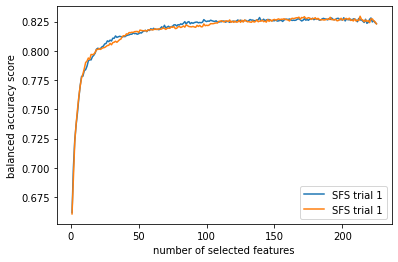

In [20]:
plt.plot(f_225_l_51_3['n_features'], f_225_l_51_3['avg_score'], f_225_l_51_4['n_features'], f_225_l_51_4['avg_score'])
#plt.title('balanced accuracy vs. number of selected features')
plt.legend(['SFS trial 1', 'SFS trial 1'])
plt.xlabel('number of selected features')
plt.ylabel('balanced accuracy score')

### Plot on test set

In [55]:
os.listdir('result')

['log_matrix_51.json',
 'f_20.csv',
 'f_20_1.csv',
 'f_225_1.csv',
 'f_225_2.csv',
 'f_50_1.csv',
 'f_50_2.csv',
 'random_selection_0420.json',
 'f_225_l_51_1.csv',
 'f_225_l_51_2.csv',
 'df_f_225_1_test.json',
 'rrfs_logmatrix.json',
 'random_selection_test.json',
 'f_225_l_51_3.csv',
 'f_225_l_51_4.csv']

Text(0, 0.5, 'balanced accuracy score')

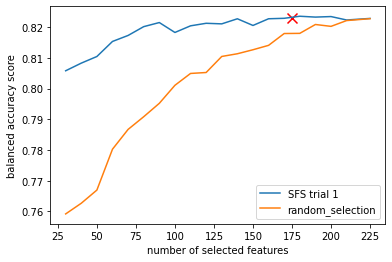

In [152]:
random_selection_51_test = pd.read_json('result/log_matrix_51.json')
SFS_3_test = pd.read_json('result\SFS_3_test.json')

plt.plot(SFS_3_test['n_feature_steps'][4:], SFS_3_test['average_score'][4:], random_selection_51_test['n_feature_steps'][4:], random_selection_51_test['average_score'][4:])
plt.scatter(175, 0.8231319302654315, marker = 'x', c = 'red', s = 100, zorder = 1)
plt.legend(['SFS trial 1', 'random_selection'])
plt.xlabel('number of selected features')
plt.ylabel('balanced accuracy score')


### Repeat on test set

In [0]:
# Only select body state label
target_label = ['LYING_DOWN', 'SITTING', 'FIX_walking', 'FIX_running', 'BICYCLING', 'OR_standing']

# Use the last 5 user's data as test set
test_uuid = list(range(56, 61))

# Fill the Nan with mean value and normalize all the data 
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())
])

# Transform 
# 1. select target labels 
# 2. tansform feature matrix fill None with mean and do the normalization
# 3. Split train, validation and test set by ratio of 6:2:2
X_new, y_new, M_new = select_target_labels(X, y, M, label_names, label_names, drop_all_zero = False)
X_new = pipeline.fit_transform(X_new, y_new)
X_train, y_train, M_train, X_val, y_val, M_val, X_test, y_test, M_test = random_split(X_new, y_new, M_new, test_size = 0.2, val_size = 0.2, random_seed = 42)

In [0]:
def repeat_selection_on_test(fs, n_feature_steps, average = 5): 
  log_matric = pd.DataFrame({'n_feature_steps':[], 'scores':[]})
  BA_list = []
  for n_feature in n_feature_steps:

    BAs = []
    for i in range(average): 
      fs.fit() 
      X_train_new = fs.transform(X_train, k_features = n_feature)
      X_test_new = fs.transform(X_test, k_features = n_feature)

      assert X_test_new.shape[1] == n_feature

      mlp.fit(X_train_new, y_train, X_test_new, y_test, M_train, M_test, report = False)
      _, _, _, BA = evaluate_model(mlp, X_test_new, y_test, abs(1-M_test))
      BAs.append(BA)

    BA_list.append(BAs)
  log_matric['n_feature_steps'] = n_feature_steps
  log_matric['scores'] = BA_list
  log_matric['average_score'] = [sum(BAs)/average for BAs in log_matric['scores']]
  log_matric['max_score'] = [max(BAs) for BAs in log_matric['scores']]

  return log_matric

class SFS_tracker():

  def __init__(self, df):
    self.df = df
  
  def feature_index(self, k_features = 175):
    indice = self.df.loc[k_features, 'features']

    return indice

  def transform(self, X, k_features = 175):

    indice = self.feature_index(k_features)

    return X[:, indice]

  def fit(self): 

    return

In [46]:
sfs_3 = SFS_tracker(f_225_l_51_3)
X_train_new = sfs_3.transform(X_train)
X_train_new.shape, X_train.shape

((226408, 175), (226408, 225))

In [49]:
sfs_3 = SFS_tracker(f_225_l_51_3)

mlp = MLP_model([16, 16], target_label, epoches = 30, learning_rate = 0.00005)
n_feature_steps = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 225]
SFS_3_log = repeat_selection_on_test(sfs_3, n_feature_steps, average = 5)

accuaracy      sensitivity    specificity    BA             
0.641046       0.694125       0.628745       0.661435       
accuaracy      sensitivity    specificity    BA             
0.651319       0.678036       0.638491       0.658264       
accuaracy      sensitivity    specificity    BA             
0.568897       0.757637       0.559605       0.658621       
accuaracy      sensitivity    specificity    BA             
0.606900       0.724340       0.606724       0.665532       
accuaracy      sensitivity    specificity    BA             
0.656819       0.653147       0.664516       0.658832       
accuaracy      sensitivity    specificity    BA             
0.710483       0.793104       0.703210       0.748157       
accuaracy      sensitivity    specificity    BA             
0.731453       0.769657       0.726004       0.747830       
accuaracy      sensitivity    specificity    BA             
0.728056       0.779037       0.722293       0.750665       
accuaracy      sensitivi

In [0]:
SFS_3_log.to_json('result\SFS_3_test.json')

In [0]:
SFS_3_log = pd.read_json('result\SFS_3_test.json')

### Repeat on single point

In [145]:
fs = select_features_by_sensors(['Loc', 'Acc', 'Gyro', 'WAcc', 'PS', 'Aud'], feature_names)
X_train_new = fs.fit_transform(X_train)
X_test_new = fs.transform(X_test)
X_train_new.shape

(226408, 175)

In [146]:
mlp = MLP_model([16, 16], target_label, epoches = 30, learning_rate = 0.00005)
BA_list = []
for i in range(10): 
  mlp.fit(X_train, y_train, X_test, y_test, M_train, M_test, report = False)
  _, _, _, BA = evaluate_model(mlp, X_test, y_test, abs(1-M_test))
  BA_list.append(BA)

accuaracy      sensitivity    specificity    BA             
0.794732       0.860161       0.787317       0.823739       
accuaracy      sensitivity    specificity    BA             
0.802010       0.851369       0.797096       0.824233       
accuaracy      sensitivity    specificity    BA             
0.794069       0.860179       0.787160       0.823670       
accuaracy      sensitivity    specificity    BA             
0.795316       0.863053       0.789999       0.826526       
accuaracy      sensitivity    specificity    BA             
0.796307       0.859636       0.791157       0.825397       
accuaracy      sensitivity    specificity    BA             
0.811929       0.829235       0.809969       0.819602       
accuaracy      sensitivity    specificity    BA             
0.803843       0.840841       0.800071       0.820456       
accuaracy      sensitivity    specificity    BA             
0.809616       0.836287       0.806821       0.821554       
accuaracy      sensitivi

In [147]:
sum(BA_list)/10

0.8231319302654315

# RRFS trials

## Prepared the instance with missing features smaller than 20

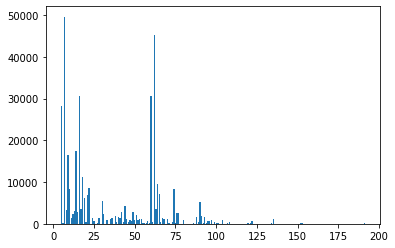

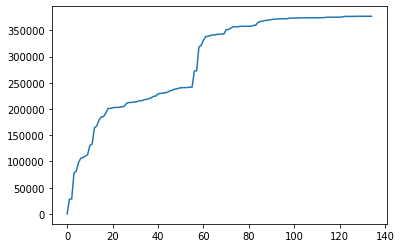

In [90]:
# Try to only select instance without any missing
df = pd.DataFrame(X)
num, freq = np.unique(np.array(sorted(df.isnull().sum(axis = 1))), return_counts = True)

plt.bar(num, freq)
plt.show()
plt.plot([sum(freq[:i]) for i in range(len(freq))])
plt.show()

In [0]:
new_indice = np.array(sorted(df.isnull().sum(axis = 1))) > 20

In [0]:
X_new = X[new_indice, :]
y_new = y[new_indice, :]
M_new = M[new_indice, :]

X_new, y_new, M_new = select_target_labels(X_new, y_new, M_new, target_label, label_names, drop_all_zero = False)
X_new = pipeline.fit_transform(X_new, y_new)
X_train, y_train, M_train, X_val, y_val, M_val, X_test, y_test, M_test = random_split(X_new, y_new, M_new, test_size = 0, val_size = 0.2, random_seed = 42)

In [166]:
X_val.shape, y_val.shape, M_val.shape

((38347, 225), (38347, 6), (38347, 6))

## Use the new data to train RRFS

In [175]:
rrfs = RRFS(225)
rrfs.train_autoencoder(X_train, X_val = X_val)

Train on 153391 samples, validate on 38347 samples
Epoch 1/100
153391/153391 [==============================] - 2s 12us/step - loss: 0.6621 - val_loss: 0.5382
Epoch 2/100
153391/153391 [==============================] - 2s 11us/step - loss: 0.5259 - val_loss: 0.5101
Epoch 3/100
153391/153391 [==============================] - 2s 11us/step - loss: 0.5044 - val_loss: 0.4927
Epoch 4/100
153391/153391 [==============================] - 2s 11us/step - loss: 0.4888 - val_loss: 0.4840
Epoch 5/100
153391/153391 [==============================] - 2s 11us/step - loss: 0.4808 - val_loss: 0.4774
Epoch 6/100
153391/153391 [==============================] - 2s 11us/step - loss: 0.4768 - val_loss: 0.4742
Epoch 7/100
153391/153391 [==============================] - 2s 11us/step - loss: 0.4745 - val_loss: 0.4730
Epoch 8/100
153391/153391 [==============================] - 2s 12us/step - loss: 0.4728 - val_loss: 0.4718
Epoch 9/100
153391/153391 [==============================] - 2s 11us/step - loss: 0.4

In [0]:
## Reload the data here
X, y, M, user_index, feature_names, label_names = load_all_data()

# Only select body state label
target_label = ['LYING_DOWN', 'SITTING', 'FIX_walking', 'FIX_running', 'BICYCLING', 'OR_standing']

# Use the last 5 user's data as test set
test_uuid = list(range(56, 61))

# Fill the Nan with mean value and normalize all the data 
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())
])

# Transform 
# 1. select target labels 
# 2. tansform feature matrix fill None with mean and do the normalization
# 3. Split train, validation and test set by ratio of 6:2:2
X_new, y_new, M_new = select_target_labels(X, y, M, target_label, label_names, drop_all_zero = False)
X_new = pipeline.fit_transform(X_new, y_new)
X_train, y_train, M_train, X_val, y_val, M_val, X_test, y_test, M_test = random_split(X_new, y_new, M_new, test_size = 0.2, val_size = 0.2, random_seed = 42)

In [110]:
mlp = MLP_model([16, 16], target_label, epoches = 20, learning_rate = 0.00005)
n_feature_steps = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 225]
repeat_selection_on_test(rrfs, n_feature_steps, average = 5)

accuaracy      sensitivity    specificity    BA             
0.524736       0.631355       0.509161       0.570258       
accuaracy      sensitivity    specificity    BA             
0.513504       0.649865       0.496914       0.573389       
accuaracy      sensitivity    specificity    BA             
0.483939       0.677736       0.459621       0.568679       
accuaracy      sensitivity    specificity    BA             
0.472664       0.702291       0.444659       0.573475       
accuaracy      sensitivity    specificity    BA             
0.569014       0.564282       0.570747       0.567515       
accuaracy      sensitivity    specificity    BA             
0.657825       0.653244       0.626696       0.639970       
accuaracy      sensitivity    specificity    BA             
0.663362       0.612899       0.663303       0.638101       
accuaracy      sensitivity    specificity    BA             
0.656726       0.623006       0.639363       0.631185       
accuaracy      sensitivi

,n_feature_steps,scores,average_score,max_score
0,1,"[0.5702577221889523, 0.5733894565572112, 0.568...",0.570663,0.573475
1,5,"[0.6399698519858834, 0.6381010212664303, 0.631...",0.636294,0.639970
2,10,"[0.714375031281984, 0.7002995681792967, 0.7044...",0.708556,0.714375
3,20,"[0.746239362722509, 0.7442831790720906, 0.7405...",0.741411,0.746239
4,30,"[0.7837772540639212, 0.7809635745223308, 0.779...",0.782236,0.783897
5,40,"[0.7877356453416349, 0.7837455138076255, 0.785...",0.784848,0.787740
6,50,"[0.8004389696701417, 0.8050298326714028, 0.803...",0.803299,0.806624
7,60,"[0.809294306327479, 0.8105582992377697, 0.8154...",0.810693,0.815445
8,70,"[0.8195043004645655, 0.816046310583658, 0.8186...",0.817731,0.819504
9,80,"[0.8222259650852886, 0.8228027535929462, 0.821...",0.821254,0.822803


In [0]:
average_score = [0.570663, 0.636294, 0.708556, 0.741411, 0.782236, 0.784848, 0.803299, 0.810693, 0.817731, 0.821254, 0.824001, 0.826579, 0.827354, 0.830215, 0.832034, 0.830180, 0.829573, 0.833488, 0.832761, 0.833893, 0.839000, 0.838013, 0.838896, 0.837934]
rrfs_new_train_test = pd.DataFrame({'n_feature_steps':n_feature_steps, 'average_score': average_score})
rrfs_new_train_test.to_json('result\rrfs_new_train_test.json')

## Plot with SFS and random

Text(0, 0.5, 'balanced accuracy score')

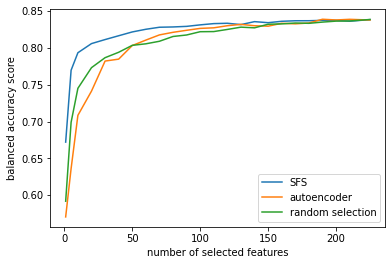

In [116]:
plt.plot(SFS_test['n_feature_steps'], SFS_test['average_score'], rrfs_new_train_test['n_feature_steps'], rrfs_new_train_test['average_score'], Random_test['n_feature_steps'], Random_test['average_score'])
#plt.title('balanced accuracy vs. number of selected features')
plt.legend(['SFS', 'autoencoder', 'random selection'])
plt.xlabel('number of selected features')
plt.ylabel('balanced accuracy score')

## Hist plot of distribution of feature scores

In [169]:
rrfs = RRFS(225)
rrfs.train_autoencoder(X_train, X_val = X_val)

Train on 153391 samples, validate on 38347 samples
Epoch 1/100
153391/153391 [==============================] - 2s 12us/step - loss: 0.6757 - val_loss: 0.5444
Epoch 2/100
153391/153391 [==============================] - 2s 11us/step - loss: 0.5292 - val_loss: 0.5118
Epoch 3/100
153391/153391 [==============================] - 2s 11us/step - loss: 0.5058 - val_loss: 0.4957
Epoch 4/100
153391/153391 [==============================] - 2s 11us/step - loss: 0.4911 - val_loss: 0.4843
Epoch 5/100
153391/153391 [==============================] - 2s 11us/step - loss: 0.4820 - val_loss: 0.4778
Epoch 6/100
153391/153391 [==============================] - 2s 11us/step - loss: 0.4773 - val_loss: 0.4742
Epoch 7/100
153391/153391 [==============================] - 2s 11us/step - loss: 0.4745 - val_loss: 0.4740
Epoch 8/100
153391/153391 [==============================] - 2s 11us/step - loss: 0.4729 - val_loss: 0.4709
Epoch 9/100
153391/153391 [==============================] - 2s 12us/step - loss: 0.4

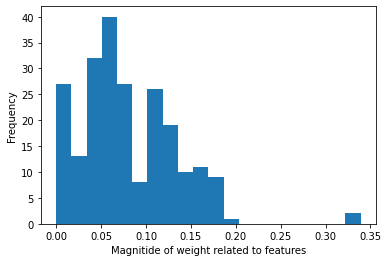

In [174]:
scores = rrfs.feature_scores()
plt.hist(scores, bins = 20)
plt.ylabel('Frequency')
plt.xlabel('Magnitide of weight related to features')
plt.show()

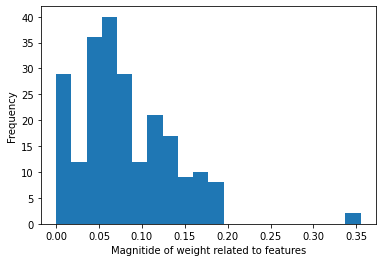

In [176]:
scores = rrfs.feature_scores()
plt.hist(scores, bins = 20)
plt.ylabel('Frequency')
plt.xlabel('Magnitide of weight related to features')
plt.show()